### Importing the Libraries

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import re
import evaluate
import torch
import matplotlib.pyplot as plt
import pandas as pd

### Step 1: Dataset preparation and preprocessing

#### Dataset used: https://huggingface.co/datasets/FiscalNote/billsum

##### Printed the dataset size,structure and first sample from traning data.

In [44]:
from datasets import load_dataset

f_dtset = load_dataset("billsum")
dataset = load_dataset("billsum",split="train")

print(f_dtset)
dataset[0]

DatasetDict({
    train: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 18949
    })
    test: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 3269
    })
    ca_test: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 1237
    })
})


{'text': "SECTION 1. LIABILITY OF BUSINESS ENTITIES PROVIDING USE OF FACILITIES \n              TO NONPROFIT ORGANIZATIONS.\n\n    (a) Definitions.--In this section:\n            (1) Business entity.--The term ``business entity'' means a \n        firm, corporation, association, partnership, consortium, joint \n        venture, or other form of enterprise.\n            (2) Facility.--The term ``facility'' means any real \n        property, including any building, improvement, or appurtenance.\n            (3) Gross negligence.--The term ``gross negligence'' means \n        voluntary and conscious conduct by a person with knowledge (at \n        the time of the conduct) that the conduct is likely to be \n        harmful to the health or well-being of another person.\n            (4) Intentional misconduct.--The term ``intentional \n        misconduct'' means conduct by a person with knowledge (at the \n        time of the conduct) that the conduct is harmful to the health \n        or w

#### Analyzing the training dataset and printing the number of samples,Average document & summary length and vocabulary size from a sample estimated. 

In [31]:
df = pd.DataFrame(dataset)

n_data = len(df)
d_length = df['text'].apply(lambda x: len(x.split()))
s_length = df['summary'].apply(lambda x: len(x.split()))

avg_dlen = d_length.mean()
avg_slen = s_length.mean()

def get_vocab(texts):
    sen = []
    for i in texts:
        sen += re.findall(r'\b\w+\b', i.lower())
    return set(sen)

ex_text = df['text'].sample(n=200, random_state=42)
ex_summary = df['summary'].sample(n=200, random_state=42)
vocab = get_vocab(ex_text) | get_vocab(ex_summary)
n_vocab = len(vocab)

print(f"Number of Samples: {n_data}")

print(f"Average document length: {avg_dlen:.2f} words")
print(f"Average summary length: {avg_slen:.2f} words")

print(f"Vocabulary size : {n_vocab}")


Number of Samples: 18949
Average document length: 1289.39 words
Average summary length: 179.12 words
Vocabulary size : 10133


##### Visualizing the distributin of document and summary lengths

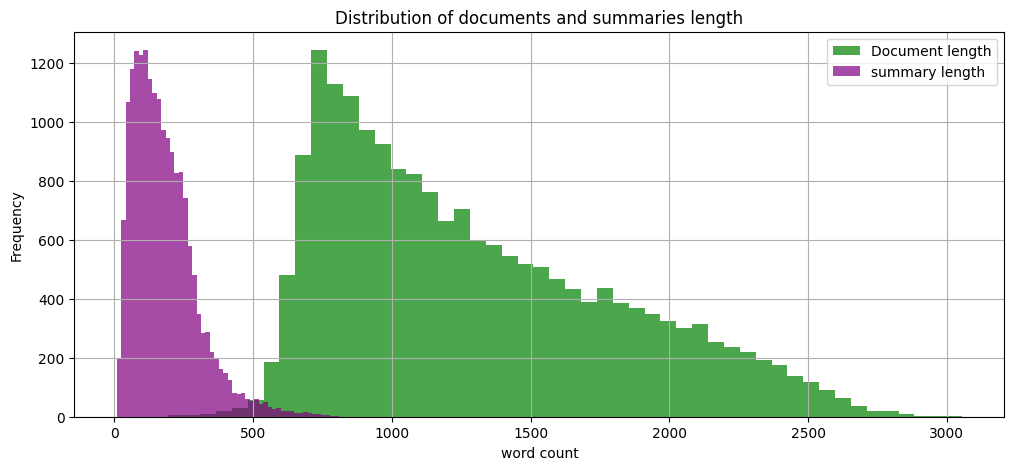

In [37]:
plt.figure(figsize=(12, 5))
plt.hist(d_length, bins=50, alpha=0.7, label='Document length',color='green')
plt.hist(s_length, bins=50, alpha=0.7, label='summary length',color='purple')
plt.xlabel('word count')
plt.ylabel('Frequency')
plt.title('Distribution of documents and summaries length')
plt.legend()
plt.grid(True)
plt.show()

#### Tokenizing the documents and their summaries using `BartTokenizer` from pretrained facebook/bart-base.
#### Split the dataset into train, val and test. (val split was from train data 90/10)

In [45]:
from transformers import BartTokenizer

tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")

max_inp_len = 1024
max_out_len = 256

def tokenizing(data):
    model_inp = tokenizer(
        data["text"], max_length=max_inp_len, padding="max_length", truncation=True
    )
    labels = tokenizer(
        data["summary"], max_length=max_out_len, padding="max_length", truncation=True
    )
    model_inp["labels"] = labels["input_ids"]
    return model_inp

train_full = f_dtset["train"]
test_dt = f_dtset["test"]

dataset_split = train_full.train_test_split(test_size=0.1, seed=42)
train_dt = dataset_split["train"]
val_dt = dataset_split["test"]

tokenized_train = train_dt.map(tokenizing, batched=True, remove_columns=["text", "summary", "title"])
tokenized_val = val_dt.map(tokenizing, batched=True, remove_columns=["text", "summary", "title"])
tokenized_test = test_dt.map(tokenizing, batched=True, remove_columns=["text", "summary", "title"])  


Map:   0%|          | 0/17054 [00:00<?, ? examples/s]

Map:   0%|          | 0/1895 [00:00<?, ? examples/s]

Map:   0%|          | 0/3269 [00:00<?, ? examples/s]

#### Saving the tokenized dataset

In [46]:
tokenized_train.save_to_disk("train_Tokenized")
tokenized_val.save_to_disk("val_tokenized")
tokenized_test.save_to_disk("test_tokenized")

Saving the dataset (0/1 shards):   0%|          | 0/17054 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1895 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3269 [00:00<?, ? examples/s]

### Step 2: Model Fine-Tuning 
#### Loading the bart pretrained model and a custom `Seq2SeqTrainer` to calculate ROUGE scores.

In [47]:
from transformers import BartForConditionalGeneration, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq, Seq2SeqTrainer
from transformers import TrainingArguments


model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

class trainS2S(Seq2SeqTrainer):
    def eval_metrics(self, eval_pred):
        predictions, labels = eval_pred
        d_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
        d_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
        rouge = evaluate.load("rouge")
        rouge_res = rouge.compute(predictions=d_preds, references=d_labels, use_stemmer=True)
        rouge_res = {key: value.mid.fmeasure * 100 for key, value in rouge_res.items()}
        return {
            "rouge1": round(rouge_res["rouge1"], 2),
            "rouge2": round(rouge_res["rouge2"], 2),
            "rougeL": round(rouge_res["rougeL"], 2),
        }

In [11]:
import os
os.environ["WANDB_DISABLED"] = "true"


#### Loaded the tokenized train and val data, setting the training arguments and tuning the model using the custom `trainS2S` class with ROUGE evaluation at each epoch.


In [48]:
from datasets import load_from_disk

tokenized_train = load_from_disk("train_Tokenized").select(range(1000))
tokenized_val = load_from_disk("val_tokenized").select(range(100))

train_arg = Seq2SeqTrainingArguments(
    output_dir="./bart-results",
    eval_strategy="epoch",
    learning_rate=0.00003,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=torch.cuda.is_available(),
    logging_dir="./logs",
    logging_strategy="epoch"
)

dt_col = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

train_smar = trainS2S(
    model=model,
    args=train_arg,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=dt_col
)

train_smar.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-48-1ecd4d9ff52d>:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `trainS2S.__init__`. Use `processing_class` instead.
  train_smar = trainS2S(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,3.347700,1.813066
2,1.858500,1.619916
3,1.680700,1.594452


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=375, training_loss=2.2956268310546877, metrics={'train_runtime': 389.2952, 'train_samples_per_second': 7.706, 'train_steps_per_second': 0.963, 'total_flos': 1829209374720000.0, 'train_loss': 2.2956268310546877, 'epoch': 3.0})

#### Visualizing the Training and Validation loss over the epochs:

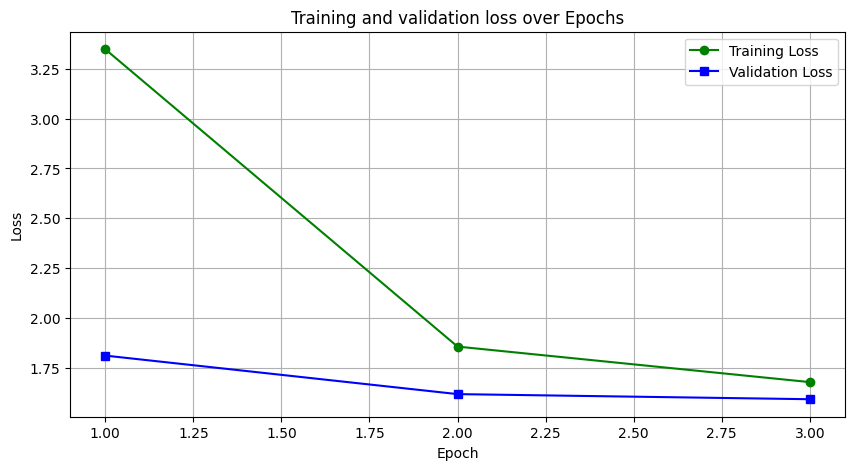

In [54]:
log_dt = pd.DataFrame(train_smar.state.log_history)

train_loss = log_dt[["epoch", "loss"]].dropna().groupby("epoch").mean().reset_index()
val_loss = log_dt[["epoch", "eval_loss"]].dropna().groupby("epoch").mean().reset_index()

plt.figure(figsize=(10, 5))
plt.plot(train_loss["epoch"], train_loss["loss"], label="Training Loss", marker="o",color="green")
plt.plot(val_loss["epoch"], val_loss["eval_loss"], label="Validation Loss", marker="s",color="blue")
plt.title("Training and validation loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


#### Evaluating the model on test data
##### generating summaries using `model.generate()`, and then computing the below:
- **ROUGE** scores,
- **BLEU** score and
- **BERTScore** .


In [71]:
from sacrebleu import corpus_bleu
from bert_score import score as bert_score

inp = [tokenizer.decode(x["input_ids"], skip_special_tokens=True) for x in tokenized_test.select(range(100))]
refs = [tokenizer.decode(x["labels"], skip_special_tokens=True) for x in tokenized_test.select(range(100))]

preds = []
model.eval()
with torch.no_grad():
    for text in inp:
        tokenized = tokenizer(text, return_tensors="pt", max_length=1024, truncation=True, padding=True)
        tokenized = {k: v.to(device) for k, v in tokenized.items()}
        output = model.generate(**tokenized, max_length=256)
        summary = tokenizer.decode(output[0], skip_special_tokens=True)
        preds.append(summary)

rouge = evaluate.load("rouge")
rouge_score = rouge.compute(predictions=preds, references=refs, use_stemmer=True)
bleu = corpus_bleu(preds, [refs])
P, R, F1 = bert_score(preds, refs, lang="en")

print("ROUGE:", {k: round(v * 100, 2) for k, v in rouge_score.items()})
print("BLEU:", round(bleu.score, 2))
print("BERTScore F1:", round(F1.mean().item() * 100, 2))


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE: {'rouge1': 47.77, 'rouge2': 27.92, 'rougeL': 34.88, 'rougeLsum': 39.8}
BLEU: 17.59
BERTScore F1: 88.17


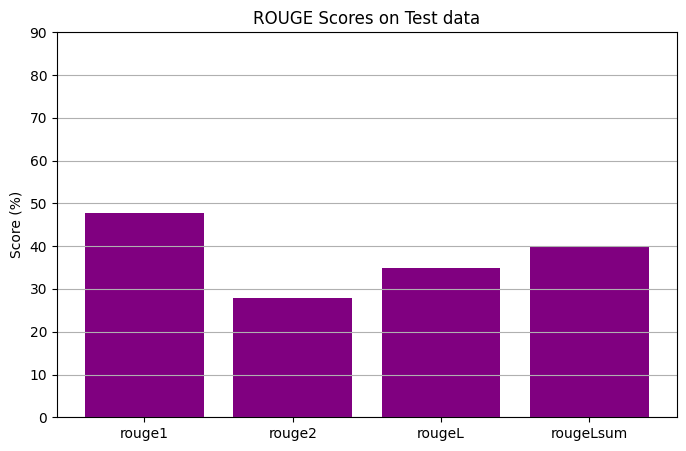

In [73]:
metrics = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
scores = [rouge_score[m] * 100 for m in metrics]

plt.figure(figsize=(8, 5))
plt.bar(metrics, scores, color='purple')
plt.title("ROUGE Scores on Test data")
plt.ylabel("Score (%)")
plt.ylim(0, 90)
plt.grid(axis='y')
plt.show()


#### Inference:
The model performed well with the results as below:
`'rouge1': 47.77, 'rouge2': 27.92, 'rougeL': 34.88` 
which indicates content overlaps with reference summaries.
The `BLEU score achieved is 17.59 and BERTScore is 88.17` showing high semantic similarity in the data.


### Challenges Faced:
- The reference summaries varied in length and level of detail, making it difficult for the model to learn a consistent way of summarizing.
- The tokenizer split long terms and names into many small parts, which increased the token count and led to earlier truncation of the input.

### Potential enhancements to improve summarization quality

- Improving summary quality by considering multiple possible word sequences during generation, which could lead to more fluent and less repetitive outputs.
- Giving short prompts like `summarize in 3 sentences` to the input can guide the model to produce summaries with desired length without modifying the structure.



### References:

https://huggingface.co/docs/transformers/en/main_classes/trainer


https://botpenguin.com/blogs/ai-text-summarization-model-using-python


https://huggingface.co/docs/transformers/en/model_doc/bart

| Team Member | Step# | Contribution (%) |
|---|---|---|
| Kisore, Indumathi  | Step 1 | 40,60  |
| Kisore, Indumathi  | Step 2 | 60,40  |
| Kisore, Indumathi | Step 3 | 30,70  |
| Kisore, Indumathi | Step 4 | 50,50  |
|   | **Total** | 100  |